# MIP Simulation

Here we calculate the sound created by minimum ionizing particles by using PyPhonon.

In [11]:
# Import libraries
import os
from pyphonon import *
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib ipympl

GPU Support Enabled


In [2]:
# Simulator parameters
max_order   = 0
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 0
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
	Fast: 0, 0 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/1 [00:00<?, ?it/s]

Estimator Generated Successfully
WARNING! Since you are using GPU accelleration you need to check that your input satisfies these conditions z < v t and (z-v t)^2 > r^2 (v^2 - 1). Otherwise there will be errors


In [3]:
# Create some additional helper functions

# Get the fast particle waves as a function of R
def get_params(r:float,v:float,T = np.array([-.1,.1]),N_pts:int=10000,GPU=GPU):
    g = 1/(v**2-1)**0.5
    z = r*g
    T = T - (r**2 + z**2)**0.5
    if GPU: t = cp.linspace(*T,N_pts)
    else: t = np.linspace(*T,N_pts)
    
    return r,z,t,v

# Calculate the average peak and FWHM
def get_peak(p,t,rel_height:float=0.8):
    peaks,_ = find_peaks(abs(p))
    results = peak_widths(abs(p),peaks,rel_height=rel_height)
    if len(peaks) == 0:
        return 0,0

    # Calculate the average width
    avg_width   = np.mean(results[0])*(t[1]-t[0])
    peak        = np.max(p[peaks])

    return peak,avg_width

# For a range of distances find the maximum
def sweep_r(R=np.linspace(0.1,100,100),v=3.0,l=2e-5,GPU=GPU):
    # Empty array to store the maxima over all the R's
    maxima  = []
    FWHM    = []

    # For each radius
    for rr in tqdm(R,desc='Radius GPU: '+str(GPU),leave=False):
        r,z,t,v = get_params(rr,v,T = np.array([-10.,10.])/v)
        p = E(r,z,t,v,l)

        # Calculate the peaks and FWHM
        if GPU: peak, avg_width = get_peak(p.get(),t.get())
        else: peak, avg_width = get_peak(p,t)

        # Append them to the appropriate arrays
        maxima.append(peak)
        FWHM.append(avg_width)

    return maxima,FWHM


# Given an array of velocities and radii predict the maxima for the supersonic speed
def get_width_max(V,R,l):
    pressure_max = []
    pressure_wid = []

    # Now do this for a range of velocities
    for v in tqdm(V,desc='Velocities'):
        MAX,WID = sweep_r(R,v,l)
        pressure_max.append(MAX)
        pressure_wid.append(WID)
        
    # Return the pressure maxima and average width
    return pressure_max,pressure_wid


# Create a figure of these measurements
def plot_pressure(V,R,pressure_max,pressure_wid):
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Plot all the thingys
    for v,pressure,width in zip(V,pressure_max,pressure_wid):
        ax1.plot(R,pressure,label=r'$v=%.1f$'%(v))
        ax2.plot(R,width,label=r'$v=%.1f$'%(v))

    # Add a legend
    ax1.legend(frameon=False)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.legend(frameon=False)
    ax2.set_yscale('log')
    ax2.set_xscale('log')

In [4]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

In [5]:
# Calculate 
V = np.linspace(0.6e8/fluids[0].sound_speed,0.8e8/fluids[0].sound_speed,3)
R = 10**np.linspace(-4,0,100)

pressure_max, pressure_wid = get_width_max(V,R,fluids[0].viscosity_coefficient()*fluids[0].sound_speed)

Velocities:   0%|          | 0/3 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

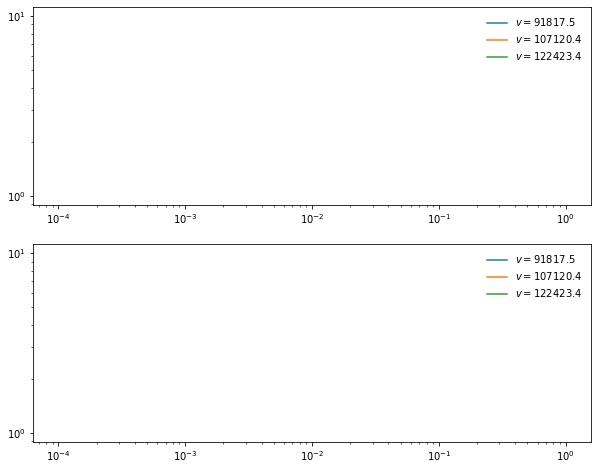

In [6]:
# Plot them
plot_pressure(V,R,pressure_max,pressure_wid)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

5.610603872855099e+27
2.942164025673701e+26
2.553117789369669e+29


  0%|          | 0/3 [00:00<?, ?it/s]

2.8347652408211083e+27
1.4750195746769683e+27
7.054307594156099e+26


  0%|          | 0/3 [00:00<?, ?it/s]

2.114096173429822e+26
8.30904785261814e+25
3.6480239760761545e+27


  0%|          | 0/3 [00:00<?, ?it/s]

2.1987879644189555e+25
5.280015634403255e+25
3.182665087216956e+26


  0%|          | 0/3 [00:00<?, ?it/s]

1.8160444770455978e+26
6.707710366254282e+24
4.5995336190248406e+24


  0%|          | 0/3 [00:00<?, ?it/s]

3.3950252725049134e+24
6.253792878187979e+23
5.615563331108466e+23


  0%|          | 0/3 [00:00<?, ?it/s]

5.861049620047602e+24
1.6539361497846462e+23
4.2833973453629885e+24


  0%|          | 0/3 [00:00<?, ?it/s]

5.289915403208888e+22
3.974881984368662e+22
1.2700233129535979e+23


  0%|          | 0/3 [00:00<?, ?it/s]

2.895031431623374e+22
7.949083886171629e+21
3.852856414670737e+23


  0%|          | 0/3 [00:00<?, ?it/s]

1.4166068293236708e+22
2.6412994977416815e+23
8.246869396431121e+21


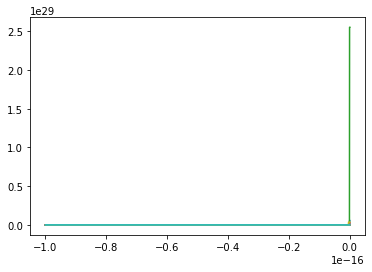

In [7]:
R = 10**np.linspace(-3,0,10)
l = fluids[0].viscosity_coefficient()*fluids[0].sound_speed
T = np.array([-1e-16,0])
N_pts= 10000

c=0
for rr in tqdm(R):
    for v in tqdm(V,leave=False):
        r,z,t,v = get_params(rr,v,T=T,N_pts=N_pts)
        p = E(r,z,t,v,l)
        print(max(abs(p)))

        plt.plot(np.linspace(*T,N_pts),p.get()+0.5*c)
#         plt.ylim(0,20)
        c+=1

In [8]:
# %matplotlib notebook
pressure_max

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]

True
True


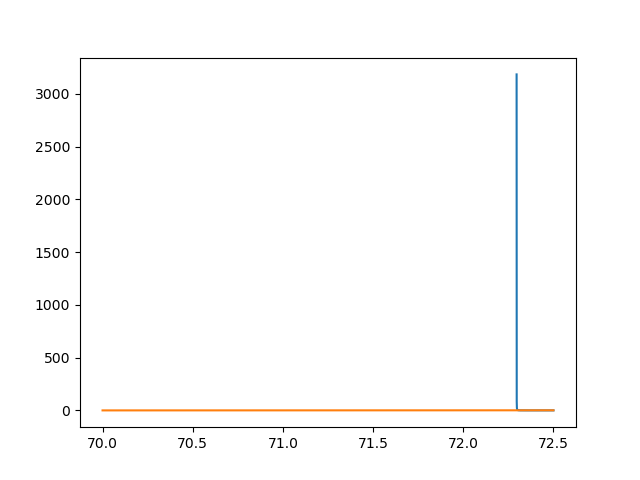

In [69]:
# Parameters
v = 4
l = 0
r = 70
t = r + cp.linspace(0,2.5,100000)
z = +cp.sqrt(-r**2/(1-v**2))

# Check conditions
A = z.get()*np.ones(len(t)) < v * t.get()
B = (abs(z - v*t) - r*cp.sqrt(v**2 - 1) > 0).get()
print(np.all(A))
print(np.any(B))

fig = plt.figure()
plt.plot(t.get(),E(r,z,t,v,l).get()*A*B)
plt.plot(t.get(),B*A*1)
plt.show()